# Fake News Classification

A problem of classification. Implemented:
- Data downloading and exploration
- Cleaning and Data preprocessing 
- Basic Explanatory Data Analysis (Visually)
- Classification of New (fake and real)
- Classifier comparison for this specific problem (Accuracy used)
- Grid search for the best classifier 
- Metrics for assessment of performance demonstration 
- ROC Curve demonstration

## Import libraries

In [1]:
#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split

## Importing the dataset

Here we import the dataset used from the public source Kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
Two different datasets about Fake and Real news are used.

In [2]:
#reading the fake and true datasets
fake_news = pd.read_csv('/home/olga/Desktop/Fake.csv')
true_news = pd.read_csv('/home/olga/Desktop/True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


## Creating the target column

Since our main goal is to classify the data we need to create a column to dinstinguish them. The column "output" created is used to separate the news to Fake (output=0) and Real (output=1). This will help to annotate the data so that the classifier can "learn" during the training and testing procedure that the data with output 0 (fake) are different from the data with output 1 (real).

In [3]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

## Concatenating title and text of news

Concatenation of title and text is done due to the fact that title can be treated as the rest of the text since it contains useful information for the classifier to learn.

In [4]:
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

## Appending two datasets

Appending of the two datasets can help the whole procedure. This way the training and testing sub-datasets can have both Fake and Real news, making the work of the classifier a little bit more difficult. It would be easier for the classifier to just learn from one Class and categorize only news coming from this specific Class, but this wouldn't solve any of our problems. Making a larger dataset we challenge the classifier to train for bigger and greater problems and we avoid overfitting.

In [9]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


## News-Punctuation Cleaning

Punctuation can stand in our way. How? By slowing down the whole procedure! Punctuation is most of the times irrelevant to the text and contains little useful information. In any case, it is problem better solved in the future for now. Our main goal is to focus on the content of the text instead.

In [10]:
#Creating a copy 
clean_news=news_dataset.copy()
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0


## News-Stop words

It wouldn't be a data cleaning process if there was no stop-word removal! Stop-words (just like punctuation) are not useful to our analysis and instead they confuse and incommode the classifiers to the extend that removing them is the best policy. Most of them are simple, small words commonly used in both Classes (Fake and Real).

In [11]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’s...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian C...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke ...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name ...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Duri...,0


## Count of fake news and true news

It is importand for the reader to be able to see the data. Visualization is an essential part of Explanatory Data Analysis. Here we ploted the count of Fake and Real news so that we can be sure that our data is balanced. We don't need 100% equality, since our dataset is fairly big in size, but we do want to make sure that no category of news wins over the other for the classifier. Our classifier needs to be familiar with both Classes, having a big sample from both.

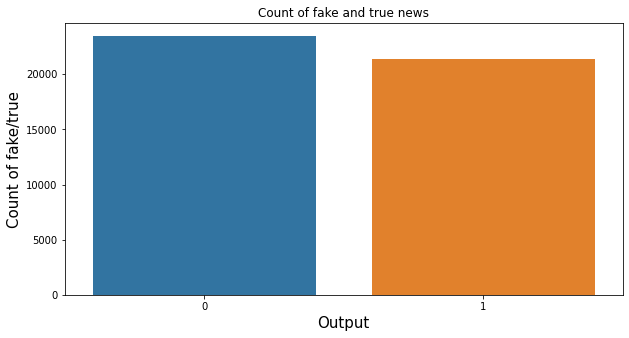

In [20]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

## Deriving new features from the news

Our dataset already provides us with some features such as the date, the title etc. But how about extracting some new features that will help us even more in the distinction between the news? We chose to extract the sentiment polarity(the sentiment that derives from the whole text), the length of the article (in lines) and the count of words. Below we plot the distributions of the extracted features from thw whole dataset. We believe that these feature will have a word on the Class of each article and will actually facilitate the classifier in its work.

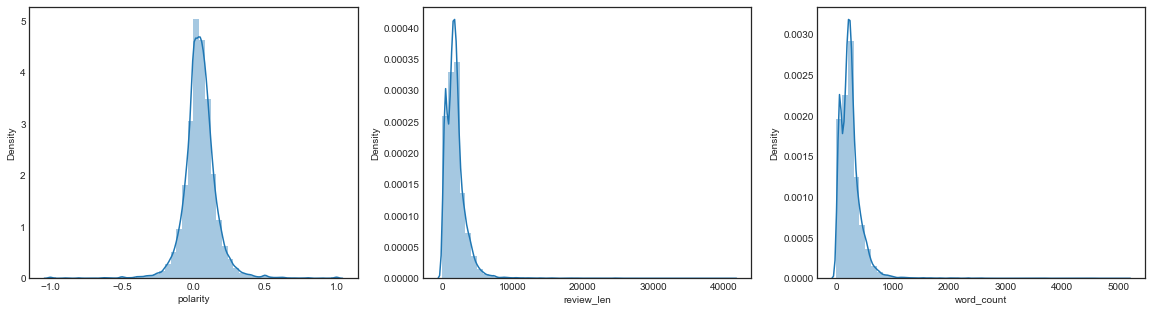

In [12]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

## Stemming & Vectorizing

Let's formally define Stemming: In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. Stemming helps us to achieve the root forms (sometimes called synonyms in search context) of inflected (derived) word, which can help in pattern recognition. Our texts (as you can see in the example below) are now stemmed!

In [13]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,Donald Trump Sends Out Embarrassing New Year’s...
1,Drunk Bragging Trump Staffer Started Russian C...
2,Sheriff David Clarke Becomes An Internet Joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name ...
4,Pope Francis Just Called Out Donald Trump Duri...


In [40]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)

In [41]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steel dossier prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york time former trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clinton top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah el sisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boy may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt democrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici pass

## TFIDF(Term Frequency — Inverse Document Frequency)

Let's clear out the TF IDF mystery! In information retrieval, tf–idf, TF*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general

Term frequency, tf(t,d), is the frequency of term t

The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents, idf(t,D)

Then tf–idf is calculated as

TF-IDF=  tf* idf

Vectorization is essential in such a computation, in order to convert words into numbers. Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics. 

If you think about it's absolutey logical. The classifier or any algorithm is no human, therefore he has his own language, which is numerical or even more specific, binary. Vector weights are the main goal to Vectorization. It is nothing more than a representation of our data. 

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

In [15]:
#Getting the target variable
y=clean_news['output']

In [16]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


## Train-test split(75:25)

Continuing with our main work, we need to split the data to the training and testing sub-datasets. This is of high importance to the classifiers correct learning. The correct way to learn is to first train your mind and memory. That is exactly ehat the classifier is doing. And it is a hard job indeed! The datatset is big and it can take up some time for it to process.. During this procedure the classifier must abide to some "IF <condition>, THEN <action> " rules. This is the way the classifier decides whether an object is meant to be in one class or the other. The procedure is both followed on the training and the testing. By why do we need two different datasets for this job to be done? In order to test the student of course! And by student meaning the classifier, whose learning must be tested. During the testing the data are not annotated. The classifier must annotate them himself using the knowledge he aqcuired from the training procedure where the data are annotated (using column "outcome"). Here, the data are splited: 75% on training (we want the classifier to have a large dataset to his disposal for variety), 25% on testing (it is not as big as training but still the dataset is radomly splitted. Therefore we can check the classifier on random data).

In [17]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Model Building: Fake News Classifier

## Model Selection

For our model we used three different classifiers.

- Logistic Regression: Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression[1] (or logit regression) is estimating the parameters of a logistic model (a form of binary regression). Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1". 

- Decision Trees: A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

- Naive Bayes: In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features (see Bayes classifier). They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

We first tarin the model containing the three classifiers and then we apply the trained model to our test data. Then the testing Accuracy (Correctly classified/All instnces) is shown. We can see that Logistic Regression did the best, but all of them have a fairly high accuarcy and very good indeed!

In [19]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,nb_cv]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9760737526748887
Decision Tree Test Accuracy: 0.9555110303300325
Naive Bayes Test Accuracy: 0.9534174992624077


## Logistic Regression with Hyperparameter Tuning

In machine learning, a hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training.

Hyperparameters can be classified as model hyperparameters, that cannot be inferred while fitting the machine to the training set because they refer to the model selection task, or algorithm hyperparameters, that in principle have no influence on the performance of the model but affect the speed and quality of the learning process. 

We conducted Hyperparameter Tuning for C and random_state. The results are noticably good! Mean accuracy is almost 0.99! Grid search can make a gid difference on the classifier therefore is a good strategy to care for it beforehand.

In [20]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=16.768329368110066, random_state=0)
The mean accuracy of the model is: 0.9874353947602923


We run again the Logistic Regression classifier on our data, having the parameteers tuned this time. The results are higher than before! In fact 99% of accuracy is indeed very good. 

In [21]:
logreg = LogisticRegression(C=24.420530945486497, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


Accuracy is one metric someone can use to assure the performance of the classification is high. What other metrics are there?

- precision= TP/TP+FP
- recall= TP/TP+FN
- F1 = (precision*recall)/ (precision + recall)

The results are consistent throughout all of metrics.That is very convenient and makes us come to the conclusion that the model really works and is competitive.

In [24]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5892
           1       0.99      0.99      0.99      5330

    accuracy                           0.99     11222
   macro avg       0.99      0.99      0.99     11222
weighted avg       0.99      0.99      0.99     11222



## ROC-AUC Curve

Another metric! But it's visual...

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning. The false-positive rate is also known as probability of false alarm and can be calculated as (1 − specificity). It can also be thought of as a plot of the power as a function of the Type I Error of the decision rule (when the performance is calculated from just a sample of the population, it can be thought of as estimators of these quantities). The ROC curve is thus the sensitivity or recall as a function of fall-out.

The higher the line is the better the classification! Here we can see we did a very fine job!

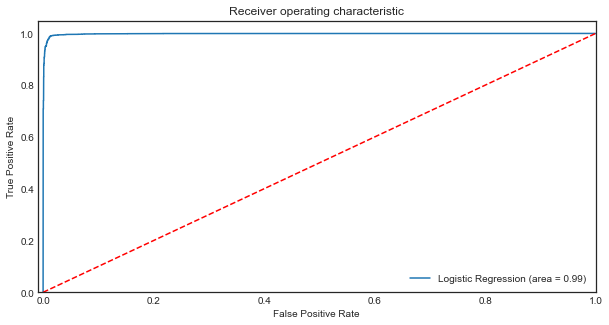

In [25]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()